 #### Question2
 #### Defining the Professional Host 

According to the literatures defining micro-entrepreneurs by the scale and intent, we can define professional landlords by using 2 core commercial criteria: lisiting numbers and commercial listing numbers. By a more specific definition, it is defined as a multi-unit operator( more than one listing) And one whose property exhibits high commercail intents by being avaliable for more than 180 daysin a year. This strongly differentiates professional from causal activity. First, hosts with multiple listings are usually not regular homeowners but professional rental businesses. Second, setting a listing's availability to more than 180 days a year is a major red flag. For example, London's rules typically limit short-term rentals to 90 days for a primary residence. Going far beyond this limit clearly moves out of the "occasional rental" category. So, while some studies use stricter criteria to define "commercial activity," our 180-day threshold​ is a practical middle ground. It effectively captures hosts who operate like "mini-hotels" due to their large scale and constant availability, without being overly restrictive.

##### Two variables that we use for defining professional landlords
Multi_listing_Hosts &
Commerical_Hosts

In [5]:
##calculating the numbers of proofessional landlords in London
import pandas as pd
import geopandas as gpd

df = pd.read_csv("20250615-London-listings (5).csv")

airbnb_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=27700)

def counting_landlords(condition):
    landlord_count = df[condition]["host_id"].nunique() 
    host_count = df["host_id"].nunique() 
    print(f"The count of all hosts in london is {host_count}.")
    print(f"The count of all professional landlords in london is {landlord_count}.")
    print(f"The proportion of professional landlords among all hosts is {landlord_count*100/host_count:.2f}%.")

Multi_listing_Hosts = df["host_listings_count"] > 1
Commerical_Hosts = df["availability_365"] >= 180

counting_landlords(Multi_listing_Hosts&Commerical_Hosts)




The count of all hosts in london is 47775.
The count of all professional landlords in london is 7224.
The proportion of professional landlords among all hosts is 15.12%.


Using basemap zoom level: 12


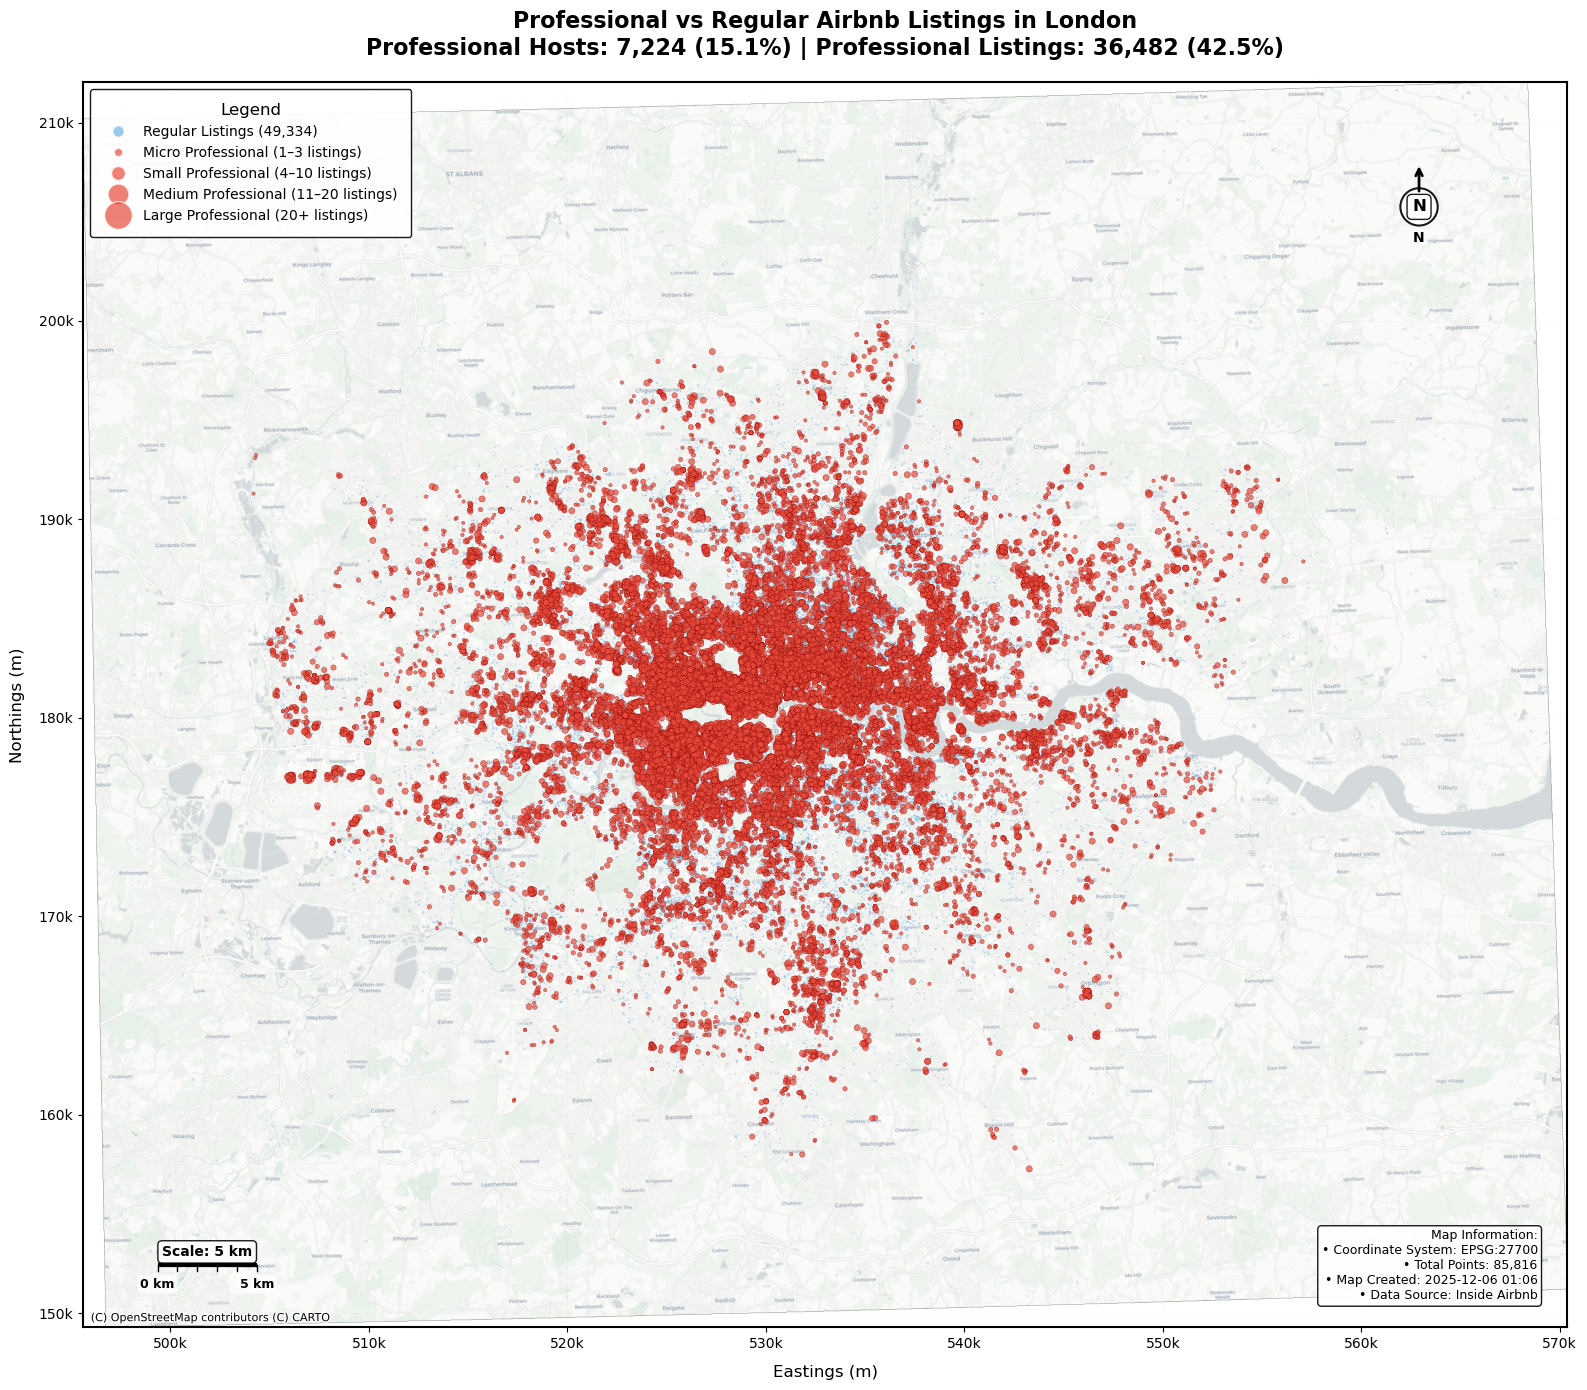

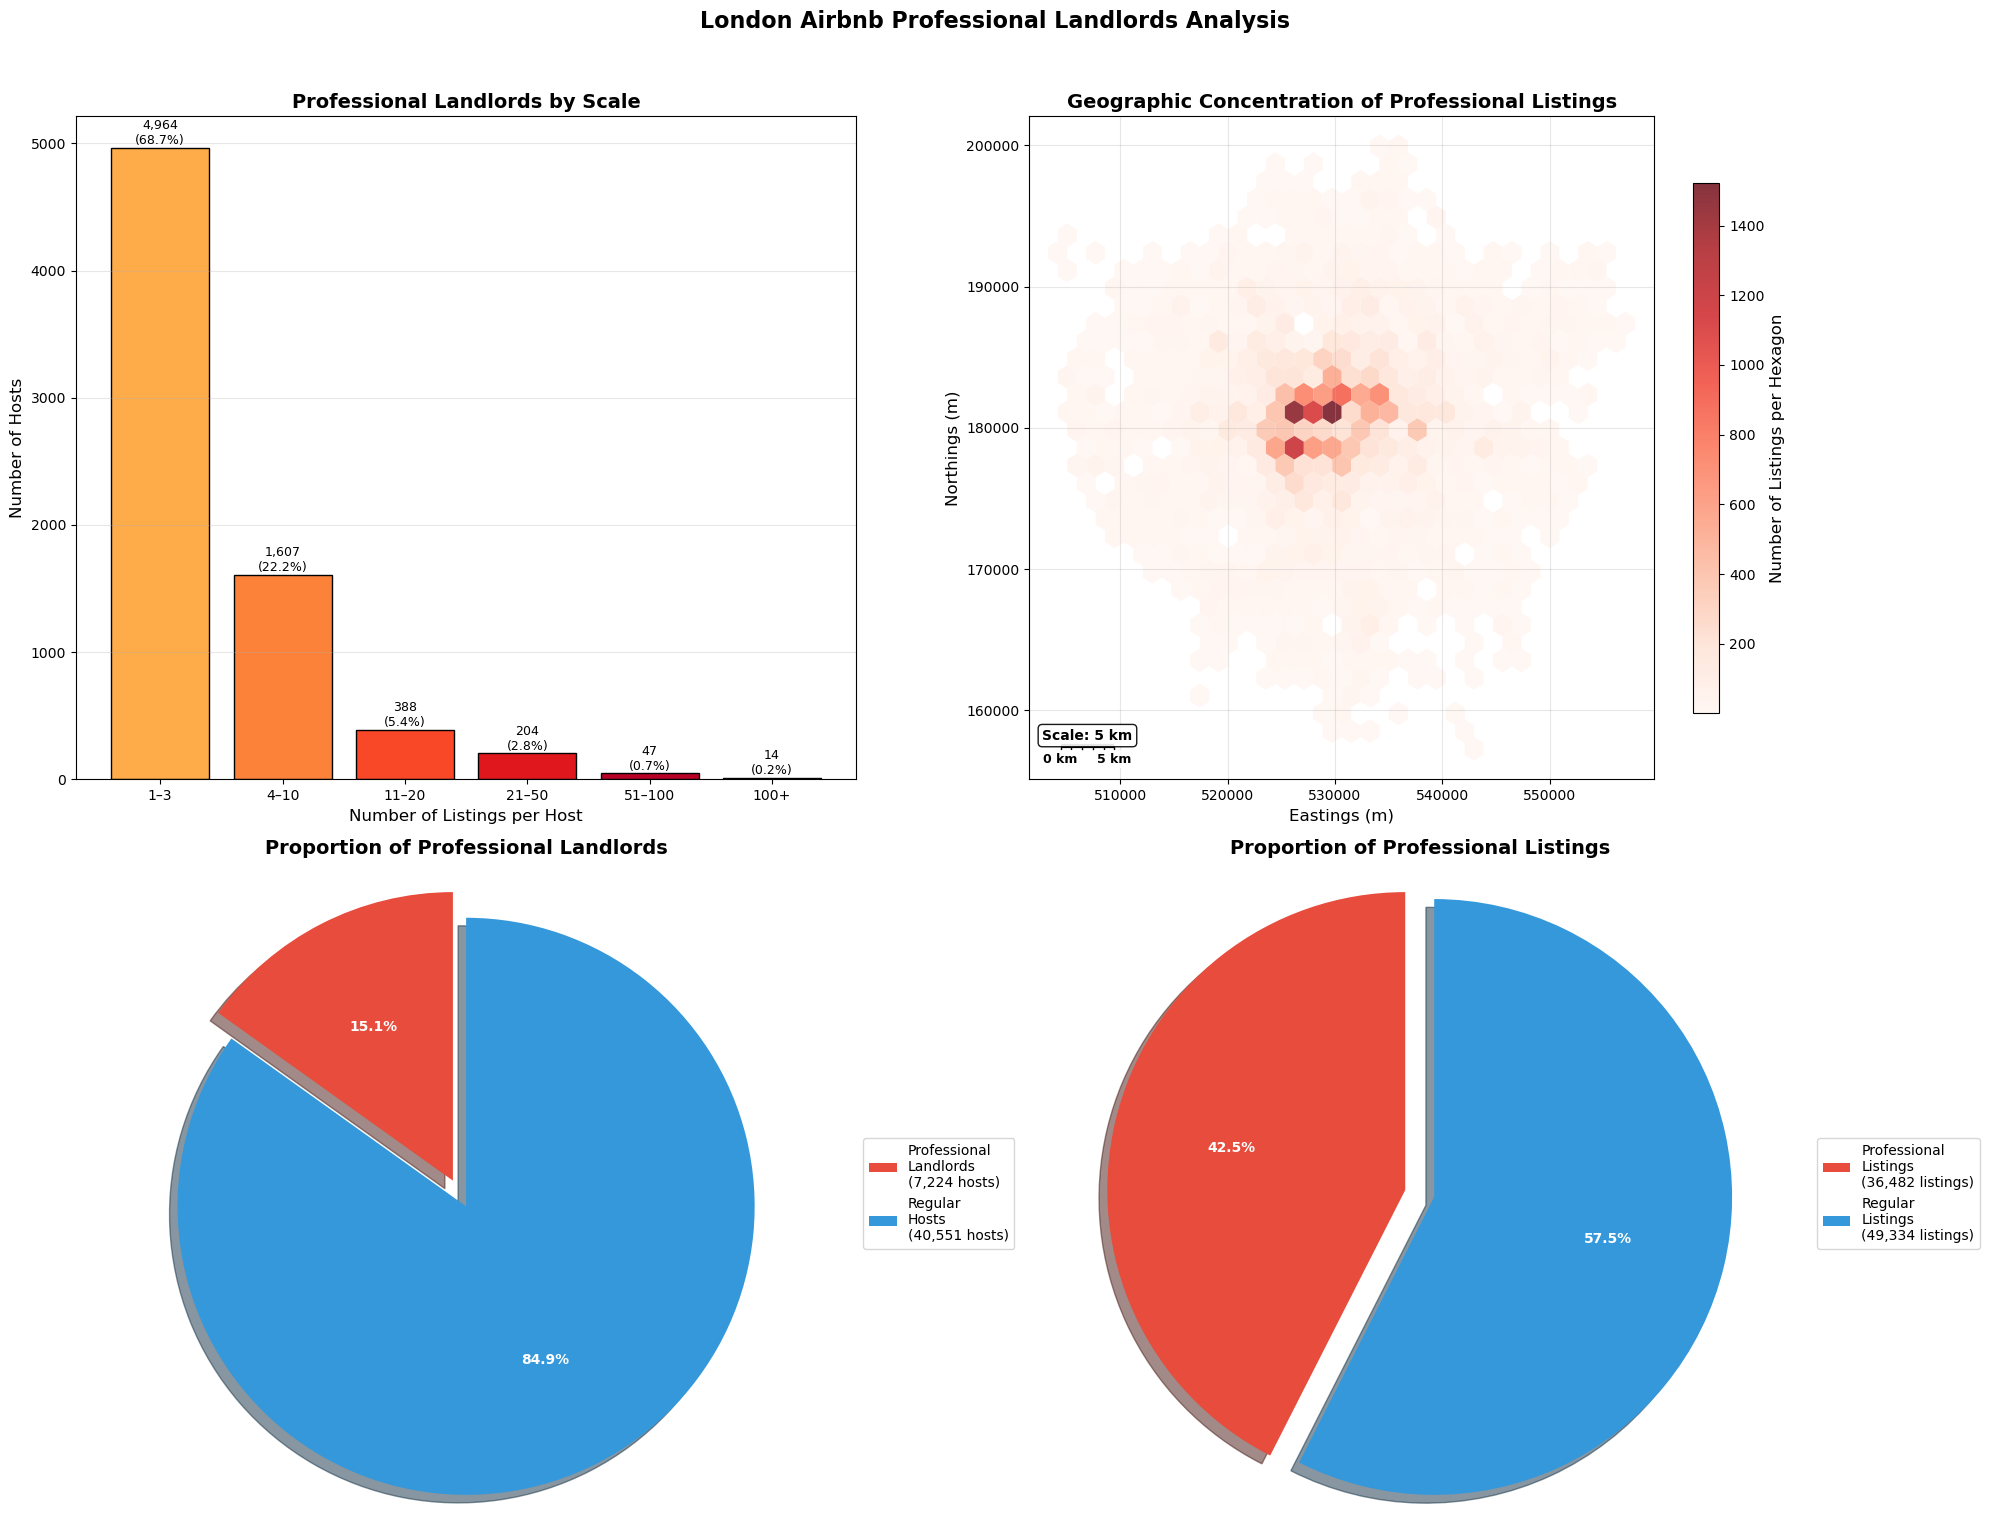


LONDON AIRBNB PROFESSIONAL LANDLORDS ANALYSIS - DETAILED STATISTICS

METRIC                                             VALUE                PERCENTAGE           RATIO     
----------------------------------------------------------------------------------------------------
Total Unique Hosts                                 47,775               100.0               % -         
Professional Landlords                             7,224                15.1                % 1:6       
Regular Hosts                                      40,551               84.9                % -         

Total Listings                                     85,816               100.0               % -         
Professional Listings                              36,482               42.5                % 1:2       
Regular Listings                                   49,334               57.5                % -         

Avg Listings per Professional                      5.05                 -                    

In [20]:
#plotting graphs to show the distribution of professional landlords
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.transforms import blended_transform_factory

# Calculate professional landlord criteria
professional_criteria = Multi_listing_Hosts & Commerical_Hosts

# Get professional host IDs
professional_host_ids = df[professional_criteria]["host_id"].unique()
all_host_ids = df["host_id"].unique()

# Mark listings belonging to professional hosts
airbnb_gdf['is_professional'] = professional_criteria
professional_listings_mask = airbnb_gdf['host_id'].isin(professional_host_ids)
professional_listings_gdf = airbnb_gdf[professional_listings_mask]
regular_listings_gdf = airbnb_gdf[~professional_listings_mask]

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(18, 14))

# 1. Compute map extent (manual zoom margin)
x_min, y_min, x_max, y_max = airbnb_gdf.total_bounds
margin = 0.1  # 10% margin
x_margin = (x_max - x_min) * margin
y_margin = (y_max - y_min) * margin

ax.set_xlim(x_min - x_margin, x_max + x_margin)
ax.set_ylim(y_min - y_margin, y_max + y_margin)

# 2. Plot regular listings
regular_listings_gdf.plot(
    ax=ax,
    color='#3498db',
    markersize=1.5,
    alpha=0.3,
    label=f'Regular Listings ({len(regular_listings_gdf):,})',
    edgecolor='none'
)

# 3. Plot professional listings with size variations
professional_sizes = []
for idx, row in professional_listings_gdf.iterrows():
    host_size = df[df['host_id'] == row['host_id']]['host_listings_count'].values[0]
    if host_size <= 3:
        size = 6
    elif host_size <= 10:
        size = 10
    elif host_size <= 20:
        size = 15
    else:
        size = 20
    professional_sizes.append(size)

professional_listings_gdf.plot(
    ax=ax,
    color='#e74c3c',
    markersize=professional_sizes,
    alpha=0.7,
    label=f'Professional Listings ({len(professional_listings_gdf):,})',
    edgecolor='darkred',
    linewidth=0.3
)

# 4. Add basemap (manual zoom to avoid warnings)
try:
    bounds = ax.get_xlim() + ax.get_ylim()
    zoom_level = 12  # Good level for London

    # Convert center coordinates to WGS84 for basemap
    from pyproj import Transformer
    center_x = (bounds[0] + bounds[1]) / 2
    center_y = (bounds[2] + bounds[3]) / 2
    transformer = Transformer.from_crs(airbnb_gdf.crs, "EPSG:4326", always_xy=True)
    center_lon, center_lat = transformer.transform(center_x, center_y)

    # Add basemap
    ctx.add_basemap(
        ax,
        crs=airbnb_gdf.crs,
        source=ctx.providers.CartoDB.Positron,
        zoom=zoom_level,
        reset_extent=False
    )

    print(f"Using basemap zoom level: {zoom_level}")

except Exception as e:
    print(f"Basemap loading failed: {e}")
    print("Using plain background instead.")
    ax.set_facecolor('#f5f5f5')

# 5. Custom scale bar (no external packages needed)
def add_scale_bar(ax, length_km=5, location='lower left'):
    """
    Add a custom scale bar to the map.
    length_km: length of scale bar (in kilometers)
    location: 'lower left', 'lower right', 'upper left', 'upper right'
    """
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    # Determine scale bar position
    if location == 'lower left':
        x_start = x_min + (x_max - x_min) * 0.05
        y_start = y_min + (y_max - y_min) * 0.05
    elif location == 'lower right':
        x_start = x_max - (x_max - x_min) * 0.05 - length_km * 1000
        y_start = y_min + (y_max - y_min) * 0.05
    elif location == 'upper left':
        x_start = x_min + (x_max - x_min) * 0.05
        y_start = y_max - (y_max - y_min) * 0.05
    elif location == 'upper right':
        x_start = x_max - (x_max - x_min) * 0.05 - length_km * 1000
        y_start = y_max - (y_max - y_min) * 0.05

    bar_length = length_km * 1000  # meters

    # Scale bar main line
    ax.plot(
        [x_start, x_start + bar_length],
        [y_start, y_start],
        color='black',
        linewidth=3,
        solid_capstyle='butt'
    )

    # Tick marks and labels
    for i in range(0, length_km + 1):
        x_pos = x_start + i * 1000
        ax.plot([x_pos, x_pos],
                [y_start, y_start - (y_max - y_min) * 0.005],
                color='black',
                linewidth=1)

        if i == 0 or i == length_km:
            ax.text(
                x_pos,
                y_start - (y_max - y_min) * 0.01,
                f'{i} km',
                ha='center',
                va='top',
                fontsize=9,
                fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8, edgecolor='none')
            )

    # Label above the bar
    ax.text(
        x_start + bar_length / 2,
        y_start + (y_max - y_min) * 0.005,
        f'Scale: {length_km} km',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor='black')
    )

# 6. Add scale bar
add_scale_bar(ax, length_km=5, location='lower left')

# 7. Add north arrow
def add_north_arrow(ax, location='upper right', size=0.05):
    """
    Add a north arrow.
    """
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    if location == 'upper right':
        arrow_x = x_max - (x_max - x_min) * 0.1
        arrow_y = y_max - (y_max - y_min) * 0.1
    elif location == 'upper left':
        arrow_x = x_min + (x_max - x_min) * 0.1
        arrow_y = y_max - (y_max - y_min) * 0.1
    elif location == 'lower right':
        arrow_x = x_max - (x_max - x_min) * 0.1
        arrow_y = y_min + (y_max - y_min) * 0.1
    elif location == 'lower left':
        arrow_x = x_min + (x_max - x_min) * 0.1
        arrow_y = y_min + (y_max - y_min) * 0.1

    arrow_length = (y_max - y_min) * 0.05

    ax.annotate(
        'N',
        xy=(arrow_x, arrow_y + arrow_length * 0.7),
        xytext=(arrow_x, arrow_y),
        arrowprops=dict(arrowstyle='->', lw=2, color='black'),
        ha='center',
        va='center',
        fontsize=12,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor='black')
    )

    circle = plt.Circle(
        (arrow_x, arrow_y),
        arrow_length * 0.3,
        facecolor='white',
        edgecolor='black',
        alpha=0.9,
        linewidth=1.5
    )
    ax.add_patch(circle)

    ax.text(
        arrow_x,
        arrow_y - arrow_length * 0.5,
        'N',
        ha='center',
        va='center',
        fontsize=10,
        fontweight='bold'
    )

# 8. Add north arrow 
add_north_arrow(ax, location='upper right')

# 9. Improved legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=f'Regular Listings ({len(regular_listings_gdf):,})',
           markerfacecolor='#3498db', markersize=8, alpha=0.5),

    Line2D([0], [0], marker='o', color='w',
           label='Micro Professional (1–3 listings)',
           markerfacecolor='#e74c3c', markersize=6, alpha=0.7),

    Line2D([0], [0], marker='o', color='w',
           label='Small Professional (4–10 listings)',
           markerfacecolor='#e74c3c', markersize=10, alpha=0.7),

    Line2D([0], [0], marker='o', color='w',
           label='Medium Professional (11–20 listings)',
           markerfacecolor='#e74c3c', markersize=15, alpha=0.7),

    Line2D([0], [0], marker='o', color='w',
           label='Large Professional (20+ listings)',
           markerfacecolor='#e74c3c', markersize=20, alpha=0.7),
]

legend = ax.legend(
    handles=legend_elements,
    loc='upper left',
    fontsize=10,
    frameon=True,
    framealpha=0.9,
    edgecolor='black',
    title='Legend',
    title_fontsize=12,
    borderpad=1
)

# 10. Map title
title_text = (
    'Professional vs Regular Airbnb Listings in London\n'
    f'Professional Hosts: {len(professional_host_ids):,} '
    f'({len(professional_host_ids)*100/len(all_host_ids):.1f}%) | '
    f'Professional Listings: {len(professional_listings_gdf):,} '
    f'({len(professional_listings_gdf)*100/len(airbnb_gdf):.1f}%)'
)
ax.set_title(title_text, fontsize=16, fontweight='bold', pad=20)

# 11. Add map info box
map_info_text = (
    f'Map Information:\n'
    f'• Coordinate System: {airbnb_gdf.crs}\n'
    f'• Total Points: {len(airbnb_gdf):,}\n'
    f'• Map Created: {pd.Timestamp.now().strftime("%Y-%m-%d %H:%M")}\n'
    f'• Data Source: Inside Airbnb'
)

ax.text(
    0.98,
    0.02,
    map_info_text,
    transform=ax.transAxes,
    fontsize=9,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor='black')
)

# 12. Grid
ax.grid(True, alpha=0.1, linestyle='--', linewidth=0.5)

# 13. Add border around map
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')

# 14. Axis labels
ax.set_xlabel('Eastings (m)', fontsize=12, labelpad=10)
ax.set_ylabel('Northings (m)', fontsize=12, labelpad=10)

# 15. Axis formatting
from matplotlib.ticker import FuncFormatter

def format_func(x, pos):
    if x >= 1000:
        return f'{x/1000:.0f}k'
    else:
        return f'{x:.0f}'

ax.xaxis.set_major_formatter(FuncFormatter(format_func))
ax.yaxis.set_major_formatter(FuncFormatter(format_func))

plt.tight_layout()
plt.show()

# 16. SECOND VISUALIZATION — Summary Statistics
fig2, axes = plt.subplots(2, 2, figsize=(20, 15))

# Subplot 1: Professional host size distribution
ax1 = axes[0, 0]
professional_hosts_data = df[df['host_id'].isin(professional_host_ids)]
host_scale = professional_hosts_data.groupby('host_id').size().reset_index(name='listings_count')

bins = [0, 3, 10, 20, 50, 100, float('inf')]
labels = ['1–3', '4–10', '11–20', '21–50', '51–100', '100+']
host_scale['scale_category'] = pd.cut(host_scale['listings_count'], bins=bins, labels=labels)

scale_counts = host_scale['scale_category'].value_counts().sort_index()

colors = plt.cm.YlOrRd(np.linspace(0.4, 1, len(scale_counts)))
bars = ax1.bar(range(len(scale_counts)), scale_counts.values, color=colors, edgecolor='black')

ax1.set_xlabel('Number of Listings per Host', fontsize=12)
ax1.set_ylabel('Number of Hosts', fontsize=12)
ax1.set_title('Professional Landlords by Scale', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(scale_counts)))
ax1.set_xticklabels(scale_counts.index)
ax1.grid(True, alpha=0.3, axis='y')

# Add labels
for i, (bar, count) in enumerate(zip(bars, scale_counts.values)):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.,
        height + 5,
        f'{count:,}\n({count/len(professional_host_ids)*100:.1f}%)',
        ha='center',
        va='bottom',
        fontsize=9
    )

# Subplot 2: Geographic concentration (hexbin)
ax2 = axes[0, 1]

if len(professional_listings_gdf) > 0:
    hb = ax2.hexbin(
        professional_listings_gdf.geometry.x,
        professional_listings_gdf.geometry.y,
        gridsize=30,
        cmap='Reds',
        mincnt=1,
        edgecolors='none',
        alpha=0.8
    )

    ax2.set_title('Geographic Concentration of Professional Listings',
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Eastings (m)', fontsize=12)
    ax2.set_ylabel('Northings (m)', fontsize=12)
    ax2.grid(True, alpha=0.3)

    add_scale_bar(ax2, length_km=5, location='lower left')

    cb = plt.colorbar(hb, ax=ax2, shrink=0.8)
    cb.set_label('Number of Listings per Hexagon', fontsize=12)


# Subplot 3: Proportion of professional landlords (pie chart)
ax3 = axes[1, 0]
categories = ['Professional\nLandlords', 'Regular\nHosts']
sizes = [len(professional_host_ids), len(all_host_ids) - len(professional_host_ids)]
colors_pie = ['#e74c3c', '#3498db']
explode = (0.1, 0)

wedges, texts, autotexts = ax3.pie(
    sizes,
    explode=explode,
    colors=colors_pie,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90,
    textprops={'fontsize': 10}
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax3.axis('equal')
ax3.set_title('Proportion of Professional Landlords', fontsize=14, fontweight='bold')
ax3.legend(
    wedges,
    [f'{cat}\n({size:,} hosts)' for cat, size in zip(categories, sizes)],
    loc='center left',
    bbox_to_anchor=(1, 0, 0.5, 1)
)

# Subplot 4: proportion of listings
ax4 = axes[1, 1]
categories_listings = ['Professional\nListings', 'Regular\nListings']
sizes_listings = [len(professional_listings_gdf), len(regular_listings_gdf)]

wedges2, texts2, autotexts2 = ax4.pie(
    sizes_listings,
    explode=explode,
    colors=colors_pie,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90,
    textprops={'fontsize': 10}
)

for autotext in autotexts2:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax4.axis('equal')
ax4.set_title('Proportion of Professional Listings', fontsize=14, fontweight='bold')
ax4.legend(
    wedges2,
    [f'{cat}\n({size:,} listings)' for cat, size in zip(categories_listings, sizes_listings)],
    loc='center left',
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.suptitle('London Airbnb Professional Landlords Analysis',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 17. Detailed statistics
print("\n" + "="*100)
print("LONDON AIRBNB PROFESSIONAL LANDLORDS ANALYSIS - DETAILED STATISTICS")
print("="*100)
print(f"\n{'METRIC':<50} {'VALUE':<20} {'PERCENTAGE':<20} {'RATIO':<10}")
print("-"*100)

stats_data = [
    ('Total Unique Hosts', len(all_host_ids), 100.0, '-'),
    ('Professional Landlords', len(professional_host_ids),
     len(professional_host_ids)*100/len(all_host_ids),
     f'1:{int(len(all_host_ids)/len(professional_host_ids))}'),
    ('Regular Hosts', len(all_host_ids) - len(professional_host_ids),
     (len(all_host_ids) - len(professional_host_ids))*100/len(all_host_ids),
     '-'),
    ('', '', '', ''),
    ('Total Listings', len(airbnb_gdf), 100.0, '-'),
    ('Professional Listings', len(professional_listings_gdf),
     len(professional_listings_gdf)*100/len(airbnb_gdf),
     f'1:{int(len(airbnb_gdf)/len(professional_listings_gdf))}'),
    ('Regular Listings', len(regular_listings_gdf),
     len(regular_listings_gdf)*100/len(airbnb_gdf), '-'),
    ('', '', '', ''),
    ('Avg Listings per Professional', avg_listings_per_professional, '-', 
     f'{avg_listings_per_professional:.1f}x average'),
    ('Avg Listings per Regular', avg_listings_per_regular, '-', '-'),
    ('Productivity Ratio', avg_listings_per_professional/avg_listings_per_regular,
     '-', f'{avg_listings_per_professional/avg_listings_per_regular:.1f}x more')
]

for metric, value, pct, ratio in stats_data:
    if metric == '':
        print()
    elif isinstance(value, float):
        if pct == '-':
            print(f"{metric:<50} {value:<20.2f} {pct:<20} {ratio:<10}")
        else:
            print(f"{metric:<50} {value:<20.2f} {pct:<20.1f}% {ratio:<10}")
    else:
        if pct == '-':
            print(f"{metric:<50} {value:<20,} {pct:<20} {ratio:<10}")
        else:
            print(f"{metric:<50} {value:<20,} {pct:<20.1f}% {ratio:<10}")

print("="*100)
